# Part 1: Exploratory Data Analysis

In [1]:
# Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, json, random, datetime

In [2]:
# Set options

%matplotlib inline
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 30)
pd.options.display.max_columns=100
pd.options.display.max_rows=100

np.random.seed(42)

In [3]:
# ignore deprecation warnings in sklearn

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load the login file

with open("logins.json") as login_file:
    login_data = json.load(login_file)

In [5]:
# Print one login data to see the data format

print(login_data['login_time'][0])

1970-01-01 20:13:18


In [7]:
# Set the series to index and create a column for count

login_df.set_index("login_time", inplace = True)
login_df['count'] = 1

In [8]:
# Resample the data to aggregate count by 15 minutes

login_by_15min = login_df.resample("15min").count()

## Daily cycles

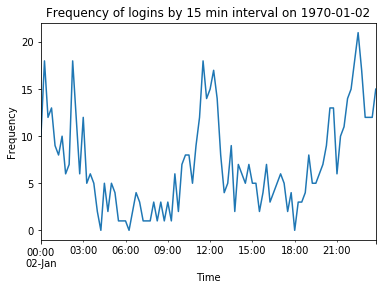

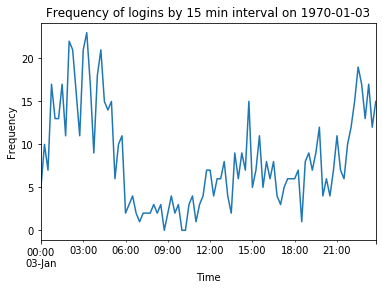

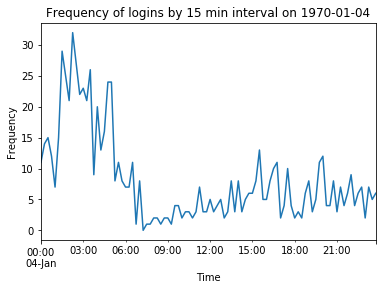

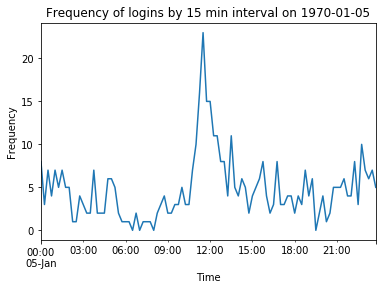

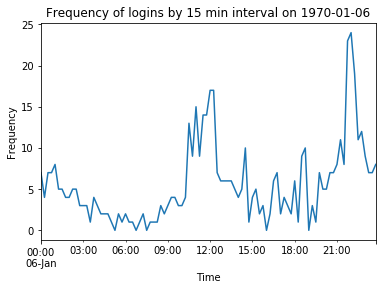

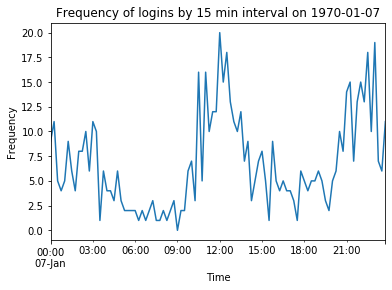

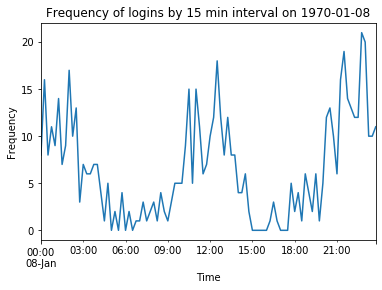

In [9]:
# Let's monitor the log-in of some days

for day in ["1970-01-02", "1970-01-03", "1970-01-04", "1970-01-05", "1970-01-06","1970-01-07", "1970-01-08"]:
    login_by_15min.loc[day].plot(legend = None)
    plt.title("Frequency of logins by 15 min interval on {0}".format(day))
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()

<font color=GREEN> For most of the days analyzed, there seems to be 2 spikes, in the evening to midnight and the noon to early afternoon. For the anomalous day of Jan 4, there are a lot of logins in the very early morning with very few logins throughout the rest of the day. We can check the day of the week those days are</font>

In [10]:
print("The day of week for January 3rd 1970 is", login_by_15min.loc["1970-01-03"].index[0].dayofweek)

The day of week for January 3rd 1970 is 5


In [11]:
print("The day of week for January 4th 1970 is", login_by_15min.loc["1970-01-04"].index[0].dayofweek)

The day of week for January 4th 1970 is 6


<font color=GREEN> We can relatively confident about the location's circadian rhythm. People often go to work with their own vehicle, then log-in at noon to go for lunch (perhaps to save on parking tickets?). Then, they might come home after work and log-in again to go out to eat and party (quite a dynamic city).</font>

<font color=GREEN></font>

## Weekly cycles

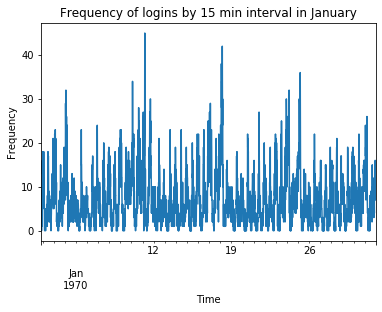

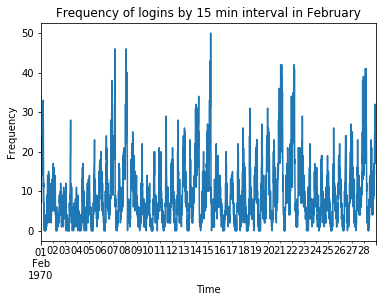

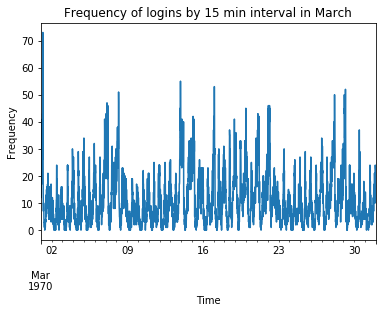

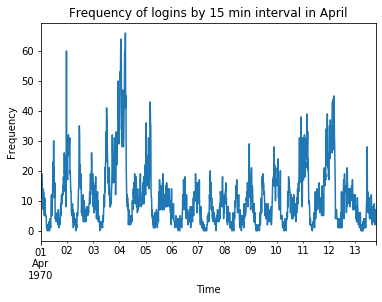

In [12]:
# Plot frequency for each month (since visualization is jaggy for all months)
m_dict = {1:"January",
         2: "February",
         3: "March",
         4: "April"}

for month in [1, 2, 3, 4]:
    login_by_15min[login_by_15min.index.month == month].plot(legend = None)
    plt.title("Frequency of logins by 15 min interval in {0}".format(m_dict[month]))
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()

<font color=GREEN>The log-in trend tends to come in a periodic pattern for all 4 months, with around 4 spike in frequency in a month (except for April, where there seems to be 2 spikes. We can check further to see where these spikes are: </font>

In [13]:
login_by_15min[(login_by_15min.index.month == 1) & (login_by_15min.index.day == 11)].index.dayofweek

Int64Index([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
            6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
            6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
            6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
            6, 6, 6, 6, 6, 6, 6, 6],
           dtype='int64', name='login_time')

<font color=GREEN>We locate the first spike of January to be the 11th day, which is on day 6 (Sunday). Due to its periodicity, we can conclude with some confidence that log-in increases during weekends. Given more time, we can try to go more granular in the weekend time to determine the exact time period of the spikes.</font>

# Part 2: Experiment and design metric

<font color=GREEN>1. The goal of the company's plan is to increase demand by tapping into the market of customers who want to travel between cities but have no drivers to take them (due to tolls). The question is whether the company will make a profit even while it is subsidizing the drivers. Thus, the key measure of success in this experiment is <b>average distance that customers will travel </b>when the subsidy is used (since the subsidy is a fixed cost and the revenue generated is per mile). If the average distance that customers travel is greater than the breakeven distance, we can conclude whether this move is worth making. Note that there are other considerations that can be taken into account if given more information about the business. For example, if the market is highly competitive and loyalty driven, we may want to implement the project even at a loss in order to increase market share.</font>

<font color=GREEN>2. A practical experiment I would devise is to answer the question if profit can be made if we subsidize the driver to go between cities. The team will hand out toll subsidy for a given sample of drivers first come first serve to apply for the program. The number of samples depends on the population of the two cities (which we can be confident about) and the number of trips a driver is expected to make between two cities (for which we can rely on past data). For the purpose of excercise, I will assume that the number of travels between cities in a month is 20,000. The level of confidence I would advise for the project is 95% since its success has mild effects on the company's operations. Since not much information or previous pilot study was mention, I will use Slovin's formula to estimate the sample size as.

$$ n = N / (1 + N * e^2) $$
$$ n = 20,000 / (1 + 20,000 * 0.05^2) $$
$$ n = 392  samples $$
    
Assuming a driver can make 40 inter-city trip in a month, we can pilot with 10 drivers. Note that we can use a better statistical test (cockran's equation) if we can ensure the assumption of normality of the trip population. Due to simplicity of the and the likelihood that the population is stable in the long run (cities don't change quite so fast), I will select the frequentist approach and run a one-tailed one-sample T-test on the sample distribution compared to the break-even travel distance. The Null hypothesis will be that the sample mean is lower than the break-even distance. If we run the test that found that we must reject the Null hypothesis and accept the Alternative hypothesis (that the sample mean is larger than the break-even distance), then we can conclude that the project is worth pursuing since it is profiting the company.
</font>

<font color=GREEN>Before endorsing any action, I would have to mention the following limitations of the plan:
- First, the plan assumes that we are currently not making profit on inter-city trips. Although drivers are extensively one-city, there are drivers who take customers accross city without the subsidy. By running this project, we might cannibalize those high profit-margin sales and operate at lower profit levels than now.
- Second, the plan may be subjected to exploitations by the drivers. For example, a driver can cross the city even when that route is not optimal to receive the subsidy. The team should be equiped with adequate technology to supervise such case.
- Thirdly, once again, the plan assumes the company's interest lies solely in profit-making. If the company has other agendas in mind, such as customer retention, acquisition, the company should re-consider the metric and experimental design.  </font>

# Part 3: Predictive modelling

## First glance and preprocessing

In [14]:
# Load data

with open("ultimate_data_challenge.json") as json_file:
    json_data = json.load(json_file)

print(json_data[0])

{'city': "King's Landing", 'trips_in_first_30_days': 4, 'signup_date': '2014-01-25', 'avg_rating_of_driver': 4.7, 'avg_surge': 1.1, 'last_trip_date': '2014-06-17', 'phone': 'iPhone', 'surge_pct': 15.4, 'ultimate_black_user': True, 'weekday_pct': 46.2, 'avg_dist': 3.67, 'avg_rating_by_driver': 5.0}


In [15]:
# Convert to dataframe

df = pd.DataFrame(json_data)

print(df.shape)
print(df.info())
print(df.describe())

(50000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None
           avg_dist  avg_rating_by_driver  avg_rating_of_driver     avg_surge  \
count  50000.000000          49799.000000          41878.000000  50000.000000   
mean       5.796827              4.778158              4.60155

In [16]:
# Convert sign_up_date and last_trip_date to datetime
df["signup_date"] = pd.to_datetime(df["signup_date"], format='%Y-%M-%d')
df["last_trip_date"] = pd.to_datetime(df["last_trip_date"], format='%Y-%M-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [17]:
# Define a function to Convert last_trip_date to label
def convert_to_label(today, last_trip_date):
    if today - last_trip_date <= datetime.timedelta(days = 30):
        return "Retained"
    else:
        return "Lost"


In [18]:
# Convert last_trip_date to label
today = max(df["last_trip_date"])

df['label'] = df["last_trip_date"].apply(lambda x: convert_to_label(today, x))

df.label.value_counts()

Retained    49112
Lost          888
Name: label, dtype: int64

In [19]:
# Convert sign-up-date to days since signup

In [20]:
df["days_since_signup"] = df["signup_date"].apply(lambda x: (today - x).days)

In [21]:
df = df.drop(["last_trip_date", "signup_date"], axis = 1)

df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,label,days_since_signup
0,3.67,5.0,4.7,1.10,King's Landing,iPhone,15.4,4,True,46.2,Retained,6
1,8.26,5.0,5.0,1.00,Astapor,Android,0.0,0,False,50.0,Retained,2
2,0.77,5.0,4.3,1.00,Astapor,iPhone,0.0,3,False,100.0,Retained,25
3,2.36,4.9,4.6,1.14,King's Landing,iPhone,20.0,9,True,80.0,Retained,21
4,3.13,4.9,4.4,1.19,Winterfell,Android,11.8,14,False,82.4,Retained,4


In [22]:
# Convert city and phone to categorical data

df["city"] = df["city"].astype('category')
df["phone"] = df["phone"].astype('category')

## Missing data imputation

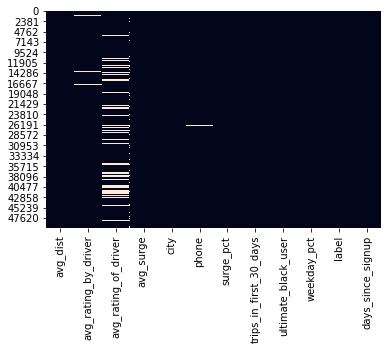

In [23]:
# Visualize missing values

sns.heatmap(df.isnull(), cbar=False)

In [24]:
# Impute average rating columns with the mean

df.fillna(df.mean(), inplace=True)

In [25]:
# Impute the phone column with the most common class

df = df.apply(lambda x: x.fillna(x.value_counts().index[0]))

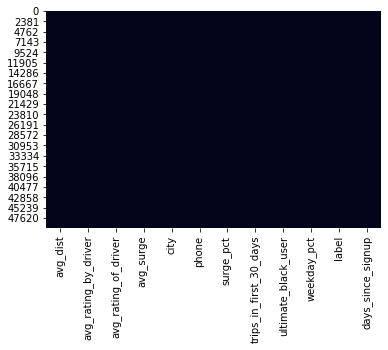

In [26]:
# Check imputation results

sns.heatmap(df.isnull(), cbar=False)

## EDA

Outliers are troublesome data-points which are extreme and skew the distribution unfairly. It is especially detrimental to Regression, so we should look to remove some of them before moving on.

<Figure size 1440x1440 with 0 Axes>

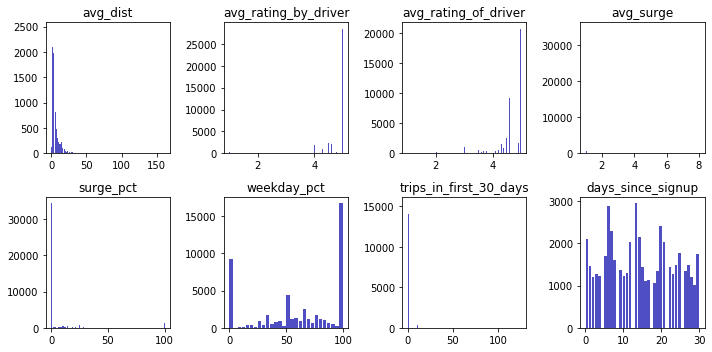

In [27]:
# Check distribution of all variables

numerics_feat = ["avg_dist", "avg_rating_by_driver", 
                 "avg_rating_of_driver", "avg_surge", 
                 "surge_pct", "weekday_pct",
                 "trips_in_first_30_days", "days_since_signup"]

plt.figure(figsize=[20,20])
f,a = plt.subplots(nrows = 2, ncols = 4, figsize=(10,5))
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(df[numerics_feat].iloc[:,idx], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
    ax.set_title(df[numerics_feat].columns[idx])
plt.tight_layout()
plt.show()

<font color=GREEN>We observe the followings:
- Average rating by driver and of driver seems distributed around the 4-5 rating.
- There's a big percentage of users only travelling in weekdays or weekends.
- There is some outliers in the avg_dist, surge_pct, trips_in_first_30_days variable that made the distribution difficult to understand, perhaps the model is better off without them. However, these data points don't seem too absurd or wrong (some customer could be travelling 150 kms average if they only took one trip at such length). Thus, we might still be able to keep them.
</font>

In [28]:
# We feature engineer two variables: weekday_user and weekend_user

df['weekday_user'] = df.weekday_pct.apply(lambda x: 1 if x == 0 else 0).astype('bool')
df['weekend_user'] = df.weekday_pct.apply(lambda x: 1 if x == 100 else 0).astype('bool')

Outliers are troublesome data-points which are extreme and skew the distribution unfairly. It is especially detrimental to parametric models like regression. On the other hand, outliers may be real data points which could help the model, so we should consider removing some of them and test to see if the removal improve the model.

In [29]:
# Next, we try to remove the outliers

print("For avg_dist, we have {} outliers".format(len(df[df.avg_dist >= 50])))

For avg_dist, we have 41 outliers


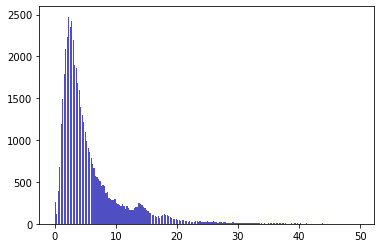

In [30]:
plt.hist(df[df.avg_dist <= 50].avg_dist, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.show()

<font color=GREEN>
The avg_dist distribution without distribution can be visualize as a normal distribution with a long right tail.
</font>

In [31]:
print("For trips_in_first_30_days, we would need to remove {} outliers".format(len(df[df.trips_in_first_30_days >= 50])))

For trips_in_first_30_days, we would need to remove 15 outliers


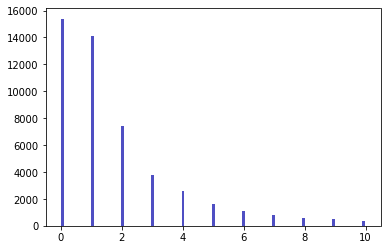

In [32]:
plt.hist(df[df.trips_in_first_30_days <= 10].trips_in_first_30_days, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.show()

<font color=GREEN>
The trips_in_first_30_days distribution looks exponential
</font>

In [33]:
print("For surge_pct, we would need to remove {} outliers".format(len(df[df.surge_pct >= 50])))

For surge_pct, we would need to remove 3091 outliers


In [34]:
print("That might be too much data for us to consider removing, as it is {}% of our dataset. Let's take a closer look at the left tail of the distribution."
      .format(len(df[df.surge_pct >= 50])/len(df)*100))

That might be too much data for us to consider removing, as it is 6.182% of our dataset. Let's take a closer look at the left tail of the distribution.


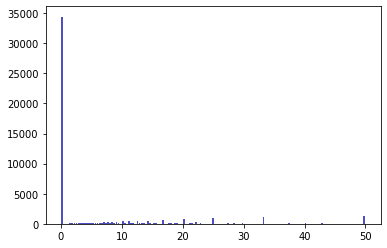

In [35]:
plt.hist(df[df.surge_pct <= 50].surge_pct, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.show()

<font color=GREEN>
The majority of the values for this variable is 0. So we might be justified in removing replacing this variable as a boolean to reduce noise.
</font>

In [36]:
df['surge_pct'] = df.surge_pct.apply(lambda x: 1 if x != 0 else 0).astype('bool')

#### Last, we try to remove the outlier to see if our models do better

df = df[(df.avg_dist <=50) & (df.trips_in_first_30_days <= 10)]

#### This step was canceled because the model did better with the outliers

In [37]:
print("The final dataframe has {} observations".format(len(df)))

The final dataframe has 50000 observations


## Random forest feature importance

In [38]:
print("The fraction of customers retained is %.2f %%" %(df.label.value_counts()[0]/len(df.label)*100))

The fraction of customers retained is 98.22 %


In [39]:
# Import random forest to visualize feature importance

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [40]:
# Define X and y, then run feature importance

X = pd.get_dummies(df, columns=["city", "phone"]).drop("label", axis = 1)
y = df.label

In [41]:
print("We have {} training features".format(len(X.columns)))

We have 16 training features


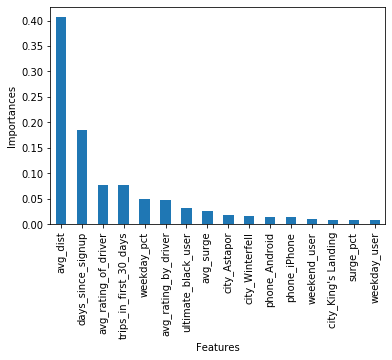

In [42]:
scaler = StandardScaler()

forest = RandomForestClassifier(n_estimators=10,
                                max_features = 'sqrt')

forest.fit(scaler.fit_transform(X), y)

importances = forest.feature_importances_

importances_df = pd.DataFrame.from_dict(dict(zip(X.columns, importances)), orient='index', columns = ["importances"])

importances_df.sort_values("importances", ascending = False).plot(kind = 'bar', legend = None)
plt.xlabel('Features')
plt.ylabel('Importances')
plt.show()

<font color=GREEN> Feature importances (which is calculated by the reduction in gini impurity once the feature is introduced) show that avg_dist, days_since_signup and trips_in_first_30_days, avg_rating_of_driver, weekday_pct, avg_rating_by_driver has a strong impact on split decision of the trees.</font>

## Modeling

<font color=GREEN> Model selection: After some consideration, I've decided to use a random forest model. There are a few reasons for my selection: 
- We have 14 features and 50,000 observations, which is very modest, we want a simple model that can run quickly and be robust to overfitting. This is close to a random forest. 
- We are trying to predict customer churn and intuitively, there's likely to be only one or two reasons customers would stop using a certain products, so I would choose a non-parametric model over a parametric one.
- We witnessed some outliers in the data, so once again, a parametric model like random forest might do better than a logistic regression model.(</font>

<font color=GREEN> I've chose precision of class 1 - The Lost class as the evaluation metric for the model due to two reasons.
- The dataset is heavily imbalanced. If we simply have it run on accuracy, the model will favor predicting the majority class (and will likely make all predictions in the majority class.
- In practical sense, we want the model to be as accurate as possible in any churn-warning prediction it makes since a large investment will have to be made to retain those customers. We would even trade that off for missing a few cases (we won't save that customer, but no investment will have been made either). 
    (</font>

In [43]:
# Import sklearn functions

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, precision_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

In [44]:
# Define X and y

X = pd.get_dummies(df, columns=["city", "phone"]).drop("label", axis = 1)
  
# Encode labels in column 'species'. 
y = LabelEncoder().fit_transform(df['label']) 
y = 1 - y

indices = df.index

# Split train and test set

Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)

## Random Forest

In [45]:
# Create pipeline which includes Scaling and Random Forest, 
# Create a classifier using Cross-validated GridSearch for the best parameters

cv = 10
metric = "precision"
steps = [('scaler', StandardScaler()), 
         ('model', RandomForestClassifier(class_weight = 'balanced'))]
pipeline = Pipeline(steps)
parameters = {'model__n_estimators':[10 , 20, 30, 40, 50],
             'model__max_features': ['auto', 'sqrt', 'log2']}

clf = GridSearchCV(pipeline, 
                   parameters, 
                   n_jobs = -1,
                   cv = cv, 
                   scoring=metric,
                   verbose = 10)
clf.fit(Xtrain, ytrain)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.0min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight='balanced',
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
         

In [46]:
# Evaluate
prec_score = precision_score(ytest, clf.predict(Xtest), average = None)
f1macro_score = f1_score(ytest, clf.predict(Xtest), average = "macro")
cm = confusion_matrix(ytest, clf.predict(Xtest))

print("The best parameters used was: ",clf.best_params_)
print("The Precision for class 1 is: ", round(prec_score[1],3))
print("Confusion matrix: \n", cm) 


The best parameters used was:  {'model__max_features': 'sqrt', 'model__n_estimators': 20}
The Precision for class 1 is:  0.571
Confusion matrix: 
 [[9788   18]
 [ 170   24]]


<font color=GREEN> <b>Summary & Implication</b>: The model scored a decent 57.1% precision score. It was able to identify correctly 24/42 (or 57.1%) at-risk customers from the test set. If it is generalizable and the results prove consistent, this means that if Ultimate invests in retaining the 42 customers pointed out by the model, it will have wasted its investment on 18 customers, but will gain 24 customers which it was supposed to have lost. Depending on the cost of the retention program and the value each customer brings, this model may or may not be viable for production.</font>

<font color=GREEN> <b>Alternatives</b>: Random forest is only the first model tested, but scored ok. A few alternatives to this approach worth experimenting to improve the precision score are other tree-based models (Gradient Boosted Trees and Extreme Boosted Trees). Finally, Linear SVC techniques commonly used for binary classification can also be tried, but I doubt with a better results.</font>

<font color=GREEN> <b>Limitations & Concerns</b>: A few concerns should be pointed out. First, a few missing data needed to be imputed, which could have skewed the accuracy of our model. It's best if Ultimate can improve its data collection process to prevent this lack of data. Next, as the company gathers more data, other models could be considered (SVM for more dimensions, deep learning for more observations) which could improve the results of our model.</font>

<font color=GREEN> <b>Final Use Case</b>: Ultimate might use this insight in an effort to improve customer retention by targetting customers who are at risk for churn with better services and promotions. (</font>